In [1]:
import pandas as pd
import numpy as np
import nltk

In [2]:
dataset = pd.read_csv("IMDB Dataset.csv")
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
# Initial Data Processing
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
dataset.drop_duplicates(keep='first', inplace=True)

In [5]:
dataset.shape

(49582, 2)

In [6]:
# Split feature and target
feature = dataset.review
target = dataset.sentiment

In [7]:
# Encoding Target
lables = {"negative": 0, "positive": 1}

target = target.replace(lables).to_numpy()

/tmp/ipykernel_1839721/2925892363.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  target = target.replace(lables).to_numpy()


## Text Processing

In [8]:
import re
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

eng_stopwords= stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [9]:
def text_processor(text):
    text = text.lower()

    # Urls (https ...)
    text = re.sub(r"(http|https)\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,6}(/\S*)?", "", text)
    # HTML tags
    text = re.sub(r"<.*?>", "", text)
    # Puncuation and special Chars
    text = re.sub("[^\w\d\s]", "", text)

    text = text.strip()

    # Stop words
    text = [word for word in text.split() if word not in eng_stopwords]
    text = " ".join(text)
    # Lemmatizer
    text = lemmatizer.lemmatize(text)

    return text

In [10]:
cleaned_feature = feature.apply(text_processor).to_numpy()

In [11]:
cleaned_feature[0]

'one reviewers mentioned watching 1 oz episode youll hooked right exactly happened methe first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordit called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awayi would say main appeal show due fact goes shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away well mannered middle 

In [12]:
# Visualization

# !pip install wordcloud

from wordcloud import WordCloud

In [13]:
pos_review = cleaned_feature[target == 0]

In [14]:
wordcloud = WordCloud(
    colormap="winter", background_color="black",width=500, height=300, max_words=100
)
image = wordcloud.generate(" ".join(pos_review))

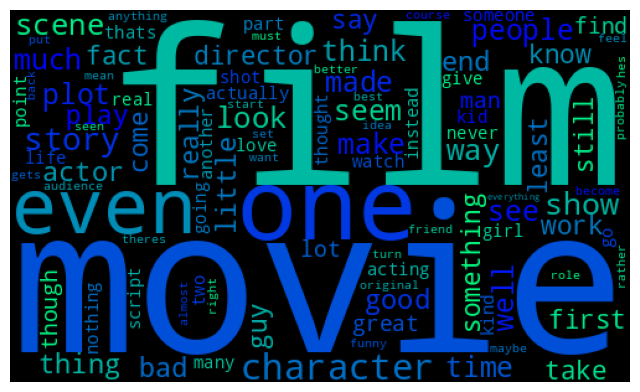

In [15]:
plt.figure(figsize=(8,8))
plt.imshow(image)
plt.axis('off')
plt.show()

In [16]:
# Word Vectorize / Embeddings

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

In [80]:
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(cleaned_feature)

In [18]:
train_tokens = [docs.split() for docs in cleaned_feature]

w2v_model = Word2Vec(
    sentences=train_tokens,
    vector_size=200,
    window=5,
    min_count=2,
)

In [19]:
def vectorize(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

X_w2v = np.array([
    vectorize(tokens, w2v_model) for tokens in train_tokens
])

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score

In [21]:
# Split train-test

X_train, X_test, y_train, y_test = train_test_split(
    X_w2v, target, test_size=0.2, stratify=target, shuffle=True, random_state=999
)

In [22]:
# model

log_reg = LogisticRegression(random_state=99)
log_reg.fit(X_train, y_train)

/home/shailesh/Desktop/VritEducation/.vritenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=99)

In [23]:
y_pred = log_reg.predict(X_test)

In [24]:
confusion_matrix(y_pred, y_test)

array([[4242,  597],
       [ 698, 4380]])

In [25]:
f1_score(y_pred, y_test)

0.8712083540527101

In [ ]:
import pickle

models_dict = {
    "embedding": w2v_model,
    "classefier": log_reg
}

with open("sentiment_model.pkl", "wb") as f:
    pickle.dump(models_dict, f)
    

# Prediction or Inference

In [26]:
user_review = "This is definitely a horror movie, increasingly by the minute. It’s also really funny — in places — and the finale combines horror and comedy in a way that doesn’t cheapen either one."
print(user_review)

This is definitely a horror movie, increasingly by the minute. It’s also really funny — in places — and the finale combines horror and comedy in a way that doesn’t cheapen either one.


In [44]:
# Save models using pkl or ..
# Load individual Models

def pred_pipe(input_text, model, vector_model):
    processed_text = text_processor(user_review)

    embeddings = vectorize(processed_text.split(), vector_model)

    predict = model.predict([embeddings])
    
    return [key for key, value in lables.items() if value == predict[0]]

In [45]:
pred_pipe(
    user_review, log_reg, w2v_model
)

['positive']